## 7장 합성곱 신경망(CNN)

### 7.2 합성곱 계층

#### 7.2.1 완전연결 계층의 문제점

완전연결 계층(Affine 계층)의 문제점은 데이터의 형상이 무시된다는 점이다. 

CNN의 Convolutional layer는 형상을 유지하기 때문에, 형상을 가진 데이터를 제대로 이해할 가능성이 있다.

CNN의 convolutional layer의 입출력은 feature map이라고도 한다. 입력은 input feature map, 출력은 output feature map.

#### 7.2.2 합성곱 연산

필터는 때때로는 커널로 불린다. 

합성곱 연산은 다음과 같은 흐름을 가진다. 

<img src="./img/fig7-4.jpg" width="40%">

결과에 편향을 더하면 출력 데이터가 나오는 흐름이다.

#### 7.2.3 패딩

합성곱 연산을 수행하기 전에 입력 데이터 주변을 특정값으로 채우는 행위를 패딩이라고 한다. 패딩은 1, 2, 3 등 다양한 값으로 적용할 수 있다.

패딩은 보통 출력 데이터의 크기를 조정하기 위해 적용한다.

<img src="./img/fig7_6.jpg" width="40%">

#### 7.2.4 스트라이드

필터(커널)을 적용하는 위치의 간격을 스트라이드라고 한다. 위 합성곱 연산은 스트라이드가 1인 예시를 다루었지만, 다음 그림은 스트라이드가 2인 경우를 나타낸다. 

<img src="./img/fig7_7.jpg" width="40%">

패딩, 스트라이드에 따른 출력 크기는 다음과 같이 계산할 수 있다. 

입력 크기를 $(H,W)$, 필터 크기를 $(FH,FW)$, 출력 크기를 $(OH, OW)$, 패딩을 $P$, 스트라이드를 $S$라고 하면, 출력 크기는 다음과 같이 계산할 수 있다.

$OH={{H+2P-FH}\over{S}}+1$

$OW={{W+2P-FW}\over{S}}+1$

다만, 출력 크기는 모두 정수로 나누어떨어져야 한다.

#### 7.2.5 3차원 데이터의 합성곱 연산

3차원 데이터의 합성곱 연산은 각 채널 별로 합성곱 연산을 수행한 결과를 다 더해서 출력 데이터를 만들어낸다. 

<img src="./img/fig7_9.jpg" width="40%">

3차원 합성곱 연산에서 주의할 점은 입력 데이터의 채널 수와 필터의 채널 수가 같아야 한다는 점이다. 또한, 모든 채널의 필터 크기가 동일해야 한다. 

#### 7.2.6 블록으로 생각하기

채널 수 $C$, 높이 $H$, 너비 $W$인 데이터의 형상은 $(C, H, W)$로 쓴다.

아래 사진에서 출력 데이터는 한 장의 feature map이다. 

<img src="./img/fig7_10.jpg" width="40%">

여러 장의 feature map은 여러개의 필터(커널)을 이용하면 만들 수 있다. 

<img src="./img/fig7_11.jpg" width="40%">

위 흐름으로 만든 feature map을 다음 계층으로 넘기는 것이 CNN의 처리 흐름이다.

합성곱 연산에서 편향이 사용되니, 편향은 다음과 같이 적용하면 된다. 편향은 채널 하나 당 값 하나씩으로 구성된다. 

<img src="./img/fig7_12.jpg" width="40%">

#### 7.2.7 배치 처리

합성곱 연산에서도 배치 처리를 할 수 있다. 배치 처리의 흐름은 다음과 같이 만들 수 있다. 각 데이터의 선두에는 배치용 차원이 추가되어 있다.

<img src="./img/fig7_13.jpg" width="40%">

### 7.3 풀링 계층

풀링은 세로, 가로 방향의 공간을 줄이는 연산이다. 아래 사진은 maxpooling을 스트라이드 2로 처리하는 과정이다. 이미지 인식 분야에서는 주로 maxpooling을 사용한다.

<img src="./img/fig7_14.jpg" width="40%">


#### 7.3.1 풀링 계층의 특징

풀링 계층은 다음과 같은 특징을 가지고 있다. 

1. 학습해야 할 매개변수가 없다
2. 채널 수가 변하지 않는다
3. 입력의 변화에 영향을 적게 받는다(강건하다)

## 7.4 합성곱/풀링 계층 구현하기

In [1]:
# img2col 함수를 분석해보자

import numpy as np

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    """ 
    np.pad : padding을 넣는다.
        input_data : padding을 넣을 데이터 
        중간에 list : 각 차원별로 어떤 크기의 padding을 넣을 것인가. 앞에 두개는 batch랑 channel이니 넣지 말고, 뒷 부분에 pad만큼의 padding을 넣는다.
        'constant' : padding 되는 값이 상수라는 것을 의미. 
    """

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            
            """ 
            img[:,:,y:y_max:stride, x:x_max:stride]의 의미. 
                filter(kernel)의 (y,x)에 해당하는 원소와 곱해질 input_data의 원소를 찾는 과정이다. 
                kernel과 input_data는 행렬곱이 아니라 행렬의 원소별 곱셈이 된다. 
            """

            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    """ 
    col.transpose(0,4,5,1,2,3)
        원래 col이 (0,1,2,3,4,5)의 차원을 가지고 있다면, 
        첫번째 위치는 그대로 두고, 
        두번째 위치에 원래 4번째를 놔두고
        세번째 위치에 원래 5번째를 놔두고... 반복한다.
        이 경우에는, 원래 col은 (batch_size=N, channel_size=C, filter_h, filter_w, out_h, out_w)를 가지고 있었지만, 
        col은 (batch_size=N, out_h, out_w, channel_size=C, filter_h, filter_w)로 차원이 달라지게 된다.  
        이거를 하는 이유는 아마 뒤에 필요없는 차원을 보내버리고, 앞에 실제로 데이터가 있는 차원을 앞으로 보내기 위함인거 같다.
    """

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [2]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    """  
    여기서 H + 2*pad + stride - 1을 해주는 이유는, padding의 영향을 받은 image를 표현하기 위해서이다. 
    """
    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [3]:
# layers.py에 정의되어 있는 Convolution

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    """ 
    col2im을 사용해야 한다는 점 이외에는 Affine 계층의 backward와 동일하다. 
    당연하지 않을까. 중간에 행렬 곱으로 가중치 곱하는 걸 구해놨으니, 그걸 역연산 한다 생각하면 dW, db는 똑같지 않을까.
    업데이트 할 때는 SGD 이용해서 업데이트 하면 될 거 같고.
     
    """
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

In [4]:
# 풀링 계층 구현하기

# 풀링을 적용할 때도 im2col을 이용하지만, 각 채널별로 적용해준다. 
# 각 행별로 최댓값을 구하고 적절한 형상으로 성형하기만 하면 된다.


class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)


        """  
        이 부분 전개에 대한 이해가 더 필요할 거 같다.
        여기서 im2col로 형태를 바꾸면, (N * out_h * out_w, -1)로 나오는데, 
        여기서 out_h = (H + 2*pad - filter_h) // stride + 1, out_w = (W + 2*pad - filter_w)//stride + 1 가 된다.
        filter_h는 pool_h, filter_w는 pool_w이다. 
        뒤의 코드를 보니, 스트라이드 값을 pool_h, pool_w랑 동일하게 준다. 그러면 maxpooling을 적용해야 하는 부분들이 가로로 모여서 반환된다.
        반환된 데이터를 reshape해서 세로로 세우면, 각 row 별 최댓값을 구하면 된다.
        """
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        """
        원래 이미지로 바꾸는 과정이다.  
        """
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


## 7.5 CNN 구현하기

In [5]:
from collections import OrderedDict
from functions import *
from layers import Relu, Affine, SoftmaxWithLoss

class SimpleConvNet:
    def __init__(self, input_dim=(1,28,28),
                 conv_param={'filter_num':30, 'filter_size':5,
                             'pad':0,'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num*(conv_output_size/2) * (conv_output_size/2))

        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b3'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()

    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x
    

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affilne1'].dW
        grads['b2'] = self.layers['Affilne1'].db
        grads['W3'] = self.layers['Affilne2'].dW
        grads['b3'] = self.layers['Affilne2'].db

        return grads



In [6]:
# 학습하기 : 실제 코드는 다음에 있음. https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch07/train_convnet.py

from mnist import load_mnist
from trainer import Trainer
from simple_convnet import SimpleConvNet
import matplotlib.pyplot as plt

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 10

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")



train loss:2.2997709838145632
=== epoch:1, train acc:0.123, test acc:0.114 ===
train loss:2.2960917726798247
train loss:2.2933912333249786
train loss:2.288697483900441
train loss:2.282109817171497
train loss:2.2634216464358317
train loss:2.2581457840739296
train loss:2.2372354888860446
train loss:2.2218764938477302
train loss:2.190099159256585
train loss:2.1669337680027096
train loss:2.1365678065975047
train loss:2.079087819965746
train loss:2.03860964413956
train loss:2.0042751055031096
train loss:1.8885632630851148
train loss:1.8669072382250262
train loss:1.7747194320993964
train loss:1.7703931335631526
train loss:1.7198046301569048
train loss:1.5398469182623784
train loss:1.5493236193880338
train loss:1.3312754905290207
train loss:1.3701917589757153
train loss:1.275938402897511
train loss:1.1885115848562773
train loss:1.0759208213617042
train loss:1.018632602324246
train loss:0.9080305831965912
train loss:1.0056067412339933
train loss:0.8597075725068517
train loss:0.8927922706557222

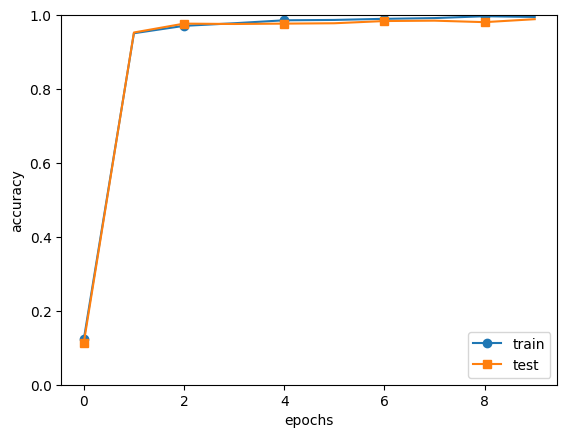

In [7]:
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()